Goal of this notebook:

Explore classifier hyperparameters to find the best combination for a single project.

Outputs: 
- Validation curves for each hyperparameter
- Best combination of hyperparameters

In [1]:
import numpy as np
import pandas as pd
from IPython.core.display import display
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRFClassifier
import warnings
import classifier_utils
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.impute import SimpleImputer
import math

In [2]:
non_features_columns = ["chunk_id", "line_start", "line_end", "line_separator", "kind_conflict", "url", "project"]
non_features_columns.extend(["project_user", "project_name", "path", "file_name", "sha", "leftsha", "rightsha", "basesha"])

In [3]:
selected_dataset = pd.read_csv("../../data/SELECTED_LABELLED_DATASET.csv")
projects = list(selected_dataset['project'].unique())

In [4]:
df_training = pd.read_csv("../../data/dataset-training.csv")
df_na = df_training[df_training.isna().any(axis=1)]

len(df_na) / len(df_training)

0.28144947636066214

In [5]:
project = ['jgralab__jgralab']

### Base classifier

In [6]:
algorithm = DecisionTreeClassifier(random_state=99)
# algorithm = RandomForestClassifier(random_state=99)
# algorithm = XGBRFClassifier(random_state=99, subsample=0.9, eval_metric='mlogloss')

In [7]:
result_algorithm = classifier_utils.ProjectsResults(algorithm, project, non_features_columns)

In [8]:
report_algorithm = result_algorithm.get_report_df(include_overall=False)
report_algorithm

,project,observations,observations (wt NaN),precision,recall,f1-score,accuracy,baseline (majority),improvement
0,jgralab__jgralab,2072,1802,0.835,0.836,0.835,0.836,0.491,0.677


### Validation curves

##### min_samples_leaf

min_samples_leaf : int or float, default=1

The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

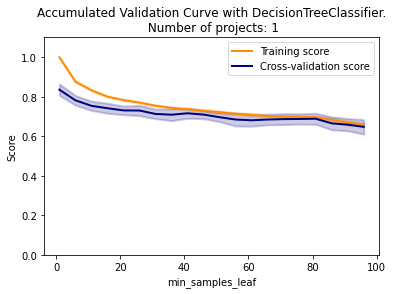

In [9]:
import importlib
importlib.reload(classifier_utils)
classifier_utils.get_validation_curve_all(project, algorithm, 'min_samples_leaf',
                                        np.arange(1, 100, 5),
                                        non_features_columns)

##### criterion

criterion : {“gini”, “entropy”}, default=”gini”

The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

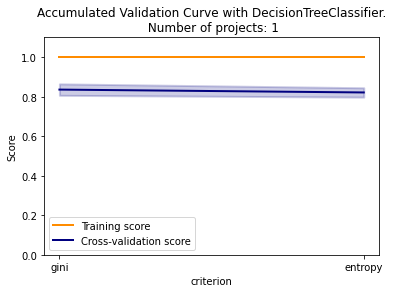

In [10]:
import importlib
importlib.reload(classifier_utils)
classifier_utils.get_validation_curve_all(project, algorithm, 'criterion',
                                        ('gini', 'entropy'),
                                        non_features_columns)

#### max_depth

max_depth : int, default=None

The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

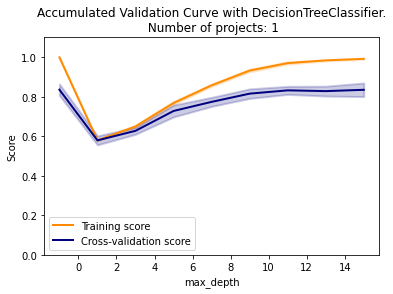

In [11]:
import importlib
importlib.reload(classifier_utils)
classifier_utils.get_validation_curve_all(project, algorithm, 'max_depth',
                                        [None, 1, 3, 5, 7, 9, 11, 13, 15],
                                        non_features_columns)

### Tuning hyperparameters


In [12]:
print("Available hyperparameters:")
algorithm.get_params()

Available hyperparameters:


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 99,
 'splitter': 'best'}

In [13]:
parameters = {'min_samples_leaf':[40,60,80],
              'max_depth':[None, 2, 4, 12]
                 }

In [14]:
results = classifier_utils.grid_search_all(project, algorithm, parameters, non_features_columns)
results.sort_values(['gold_medals', 'silver_medals', 'bronze_medals', 'total_medals'], ascending=False)

,min_samples_leaf,max_depth,mean_accuracy,total_medals,gold_medals,silver_medals,bronze_medals
0,40,NaN,0.713656,1,1,0,0
3,40,12.0,0.713656,1,1,0,0
8,80,NaN,0.688699,1,0,0,1
11,80,12.0,0.688699,1,0,0,1
1,40,2.0,0.616556,0,0,0,0
2,40,4.0,0.672600,0,0,0,0
4,60,NaN,0.682587,0,0,0,0
5,60,2.0,0.616556,0,0,0,0
6,60,4.0,0.658171,0,0,0,0
7,60,12.0,0.682587,0,0,0,0


## Comparing the models with the best parameters with the base model

In [15]:
base_model = algorithm
model_1 = DecisionTreeClassifier(random_state=99, min_samples_leaf=40, max_depth=None)
model_2 = DecisionTreeClassifier(random_state=99, min_samples_leaf=40, max_depth=12)
model_3 = DecisionTreeClassifier(random_state=99, min_samples_leaf=80, max_depth=None)

In [16]:
models = [base_model, model_1, model_2, model_3]
models_names = ['base', 'model1', 'model2', 'model3']
import importlib
importlib.reload(classifier_utils)
comparison = classifier_utils.compare_models(models, models_names, projects, non_features_columns)

C:\Users\HelenoCampos\Dropbox\SHARED_PC_LAB\Doutorado\colaboracao\conflicts_classifier\conflict-resolution-mining\scripts\classifier\classifier_utils.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['model'] = None


In [17]:
comparison.filter(regex=("model|accuracy|precision|recall")).sort_values(['accuracy'], ascending=False)

,precision,recall,accuracy,model
0,0.76944,0.76904,0.76904,base
1,0.70628,0.73124,0.73124,model1
2,0.70628,0.73124,0.73124,model2
3,0.67284,0.71592,0.71592,model3
